In [1]:
# ============================================================================
# CELL 1: IMPORT LIBRARIES
# ============================================================================
"""
Import libraries untuk modeling dan evaluation.
"""

# Data manipulation
import pandas as pd
import numpy as np
from collections import Counter

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, auc, 
    confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score,
    cohen_kappa_score, matthews_corrcoef
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
import json
import os
import joblib
from datetime import datetime
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Plot settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['savefig.dpi'] = 300

print("="*80)
print("✅ All libraries imported successfully!")
print("="*80)


✅ All libraries imported successfully!


In [2]:
# ============================================================================
# CELL 2: LOAD PROCESSED DATASETS
# ============================================================================
"""
Load train-test splits yang sudah diproses di Notebook 02.
"""

print("\n" + "="*80)
print("📂 LOADING PROCESSED DATASETS")
print("="*80)

# Load training data
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()

# Load test data
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print("\n✅ Datasets loaded successfully!")
print("-"*80)

print(f"\n📊 Training Set:")
print(f"   • X_train shape: {X_train.shape}")
print(f"   • y_train shape: {y_train.shape}")
print(f"   • Features: {X_train.shape[1]}")
print(f"   • Samples: {X_train.shape[0]}")

print(f"\n📊 Test Set:")
print(f"   • X_test shape: {X_test.shape}")
print(f"   • y_test shape: {y_test.shape}")
print(f"   • Features: {X_test.shape[1]}")
print(f"   • Samples: {X_test.shape[0]}")

# Verify feature names
print(f"\n📋 Feature Names ({len(X_train.columns)}):")
print(f"   {X_train.columns.tolist()}")

# Class distribution
train_dist = Counter(y_train)
test_dist = Counter(y_test)

print(f"\n🎯 Target Distribution:")
print(f"   Training: Class 0={train_dist[0]}, Class 1={train_dist[1]}")
print(f"   Test:     Class 0={test_dist[0]}, Class 1={test_dist[1]}")

# Data quality check
print(f"\n🔍 Data Quality Check:")
print(f"   • Missing in X_train: {X_train.isnull().sum().sum()}")
print(f"   • Missing in y_train: {np.isnan(y_train).sum()}")
print(f"   • Missing in X_test: {X_test.isnull().sum().sum()}")
print(f"   • Missing in y_test: {np.isnan(y_test).sum()}")

if X_train.isnull().sum().sum() == 0:
    print("   ✅ All datasets are clean!")


📂 LOADING PROCESSED DATASETS

✅ Datasets loaded successfully!
--------------------------------------------------------------------------------

📊 Training Set:
   • X_train shape: (1508, 24)
   • y_train shape: (1508,)
   • Features: 24
   • Samples: 1508

📊 Test Set:
   • X_test shape: (377, 24)
   • y_test shape: (377,)
   • Features: 24
   • Samples: 377

📋 Feature Names (24):
   ['Age_Encoded', 'Gender_Encoded', 'Education_Encoded', 'country_Australia', 'country_Canada', 'country_New Zealand', 'country_Other', 'country_Republic of Ireland', 'country_UK', 'country_USA', 'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Mixed-Black/Asian', 'ethnicity_Mixed-White/Asian', 'ethnicity_Mixed-White/Black', 'ethnicity_Other', 'ethnicity_White', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']

🎯 Target Distribution:
   Training: Class 0=568, Class 1=940
   Test:     Class 0=142, Class 1=235

🔍 Data Quality Check:
   • Missing in X_train: 0
   • Missing in y_train: 0
   •

In [3]:
# ============================================================================
# CELL 3: INITIALIZE BASELINE RANDOM FOREST
# ============================================================================
"""
Initialize Random Forest dengan default parameters untuk baseline.
"""

print("\n" + "="*80)
print("🌳 INITIALIZING BASELINE RANDOM FOREST")
print("="*80)

# Baseline parameters (scikit-learn defaults)
RANDOM_STATE = 42

rf_baseline = RandomForestClassifier(
    n_estimators=100,          # Default
    criterion='gini',          # Default
    max_depth=None,            # Default (unlimited)
    min_samples_split=2,       # Default
    min_samples_leaf=1,        # Default
    max_features='sqrt',       # Default for classification
    bootstrap=True,            # Default
    random_state=RANDOM_STATE,
    n_jobs=-1,                 # Use all CPU cores
    verbose=0
)

print("\n📋 Baseline Model Configuration:")
print("-"*80)
print(f"   • Model: Random Forest Classifier")
print(f"   • n_estimators: 100 (default)")
print(f"   • criterion: gini (default)")
print(f"   • max_depth: None (unlimited)")
print(f"   • min_samples_split: 2")
print(f"   • min_samples_leaf: 1")
print(f"   • max_features: sqrt")
print(f"   • bootstrap: True")
print(f"   • random_state: {RANDOM_STATE}")
print(f"   • n_jobs: -1 (all cores)")

print("\n✅ Baseline model initialized!")


🌳 INITIALIZING BASELINE RANDOM FOREST

📋 Baseline Model Configuration:
--------------------------------------------------------------------------------
   • Model: Random Forest Classifier
   • n_estimators: 100 (default)
   • criterion: gini (default)
   • max_depth: None (unlimited)
   • min_samples_split: 2
   • min_samples_leaf: 1
   • max_features: sqrt
   • bootstrap: True
   • random_state: 42
   • n_jobs: -1 (all cores)

✅ Baseline model initialized!


In [4]:
# ============================================================================
# CELL 4: TRAIN BASELINE MODEL
# ============================================================================
"""
Train baseline Random Forest pada training data.
"""

print("\n" + "="*80)
print("🎓 TRAINING BASELINE MODEL")
print("="*80)

# Record start time
start_time = datetime.now()
print(f"\n⏰ Training started: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

# Train model
print("\n🔄 Fitting Random Forest...")
rf_baseline.fit(X_train, y_train)

# Record end time
end_time = datetime.now()
training_time = (end_time - start_time).total_seconds()

print(f"✅ Training completed!")
print(f"⏱️  Training time: {training_time:.2f} seconds")

# Model info
print(f"\n📊 Model Information:")
print(f"   • Number of trees: {rf_baseline.n_estimators}")
print(f"   • Number of features: {rf_baseline.n_features_in_}")
print(f"   • Number of classes: {rf_baseline.n_classes_}")
print(f"   • Classes: {rf_baseline.classes_}")



🎓 TRAINING BASELINE MODEL

⏰ Training started: 2025-11-07 15:21:10

🔄 Fitting Random Forest...
✅ Training completed!
⏱️  Training time: 0.36 seconds

📊 Model Information:
   • Number of trees: 100
   • Number of features: 24
   • Number of classes: 2
   • Classes: [0 1]


In [5]:
# ============================================================================
# CELL 5: BASELINE PREDICTIONS
# ============================================================================
"""
Generate predictions pada training dan test sets.
"""

print("\n" + "="*80)
print("🔮 GENERATING PREDICTIONS")
print("="*80)

# Training predictions
print("\n📊 Training Set Predictions...")
y_train_pred = rf_baseline.predict(X_train)
y_train_pred_proba = rf_baseline.predict_proba(X_train)[:, 1]

print(f"   ✅ Generated {len(y_train_pred)} predictions")
print(f"   • Predicted Class 0: {(y_train_pred == 0).sum()}")
print(f"   • Predicted Class 1: {(y_train_pred == 1).sum()}")

# Test predictions
print("\n📊 Test Set Predictions...")
y_test_pred = rf_baseline.predict(X_test)
y_test_pred_proba = rf_baseline.predict_proba(X_test)[:, 1]

print(f"   ✅ Generated {len(y_test_pred)} predictions")
print(f"   • Predicted Class 0: {(y_test_pred == 0).sum()}")
print(f"   • Predicted Class 1: {(y_test_pred == 1).sum()}")

# Probability statistics
print(f"\n📈 Prediction Probability Statistics (Test Set):")
print(f"   • Min probability: {y_test_pred_proba.min():.4f}")
print(f"   • Max probability: {y_test_pred_proba.max():.4f}")
print(f"   • Mean probability: {y_test_pred_proba.mean():.4f}")
print(f"   • Median probability: {np.median(y_test_pred_proba):.4f}")


🔮 GENERATING PREDICTIONS

📊 Training Set Predictions...
   ✅ Generated 1508 predictions
   • Predicted Class 0: 568
   • Predicted Class 1: 940

📊 Test Set Predictions...
   ✅ Generated 377 predictions
   • Predicted Class 0: 149
   • Predicted Class 1: 228

📈 Prediction Probability Statistics (Test Set):
   • Min probability: 0.0200
   • Max probability: 1.0000
   • Mean probability: 0.6232
   • Median probability: 0.6900



📊 CONFUSION MATRIX ANALYSIS

🔢 Confusion Matrix - Training Set:
--------------------------------------------------------------------------------
                Predicted
               Non-User  User
Actual Non-User   568       0
       User         0     940

🔢 Confusion Matrix - Test Set:
--------------------------------------------------------------------------------
                Predicted
               Non-User  User
Actual Non-User   120      22
       User        29     206


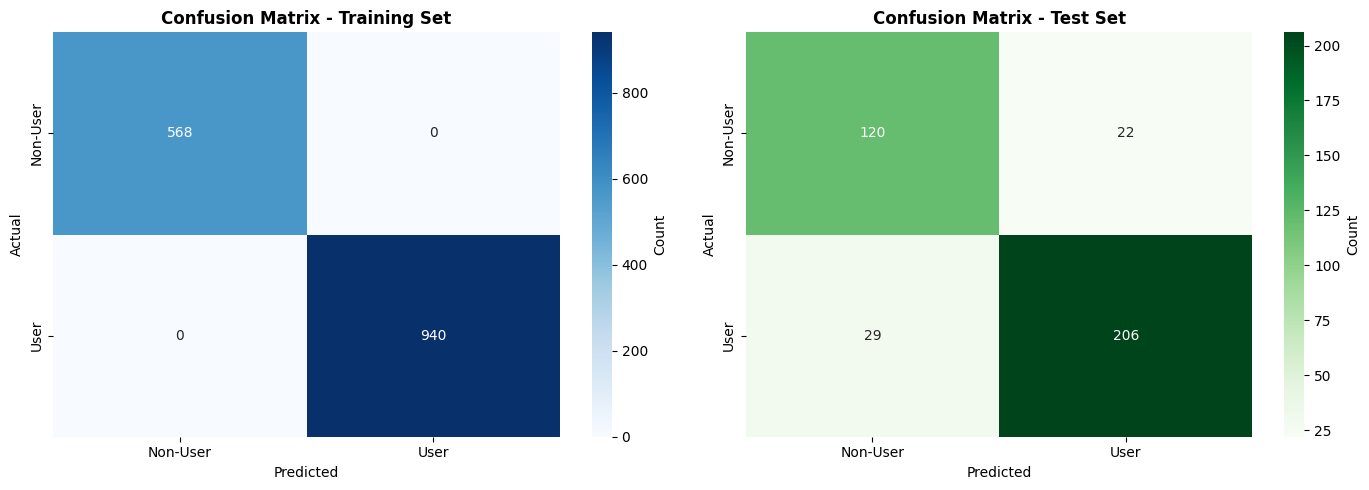


✅ Confusion matrices visualized!


In [6]:
# ============================================================================
# CELL 6: CONFUSION MATRIX
# ============================================================================
"""
Calculate dan visualize confusion matrix untuk training dan test sets.
"""

print("\n" + "="*80)
print("📊 CONFUSION MATRIX ANALYSIS")
print("="*80)

# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print("\n🔢 Confusion Matrix - Training Set:")
print("-"*80)
print(f"                Predicted")
print(f"               Non-User  User")
print(f"Actual Non-User  {cm_train[0, 0]:4d}    {cm_train[0, 1]:4d}")
print(f"       User      {cm_train[1, 0]:4d}    {cm_train[1, 1]:4d}")

print("\n🔢 Confusion Matrix - Test Set:")
print("-"*80)
print(f"                Predicted")
print(f"               Non-User  User")
print(f"Actual Non-User  {cm_test[0, 0]:4d}    {cm_test[0, 1]:4d}")
print(f"       User      {cm_test[1, 0]:4d}    {cm_test[1, 1]:4d}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-User', 'User'],
            yticklabels=['Non-User', 'User'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Training Set', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=10)
axes[0].set_xlabel('Predicted', fontsize=10)

# Test confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-User', 'User'],
            yticklabels=['Non-User', 'User'],
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('Confusion Matrix - Test Set', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=10)
axes[1].set_xlabel('Predicted', fontsize=10)

plt.tight_layout()
plt.savefig('../results/figures/19_baseline_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Confusion matrices visualized!")

In [7]:
# ============================================================================
# CELL 7: COMPREHENSIVE EVALUATION METRICS
# ============================================================================
"""
Calculate comprehensive evaluation metrics untuk baseline model.
"""

print("\n" + "="*80)
print("📏 COMPREHENSIVE EVALUATION METRICS")
print("="*80)

def calculate_metrics(y_true, y_pred, y_pred_proba, set_name=""):
    """Calculate comprehensive metrics"""
    
    # Confusion matrix elements
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)  # Sensitivity
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Specificity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Balanced accuracy
    balanced_acc = (recall + specificity) / 2
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    # PR-AUC (important for imbalanced data)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    
    # Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_true, y_pred)
    
    metrics = {
        'Set': set_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'F1-Score': f1,
        'Balanced Accuracy': balanced_acc,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'Cohen Kappa': kappa,
        'MCC': mcc,
        'True Positives': int(tp),
        'True Negatives': int(tn),
        'False Positives': int(fp),
        'False Negatives': int(fn)
    }
    
    return metrics

# Calculate metrics for both sets
print("\n🔢 Calculating metrics...")

train_metrics = calculate_metrics(y_train, y_train_pred, y_train_pred_proba, "Training")
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_proba, "Test")

# Create comparison DataFrame
metrics_df = pd.DataFrame([train_metrics, test_metrics]).set_index('Set')

print("\n📊 BASELINE MODEL PERFORMANCE:")
print("="*80)
display(metrics_df[['Accuracy', 'Precision', 'Recall (Sensitivity)', 
                     'Specificity', 'F1-Score', 'Balanced Accuracy',
                     'ROC-AUC', 'PR-AUC', 'Cohen Kappa', 'MCC']].round(4))

print("\n📊 CONFUSION MATRIX BREAKDOWN:")
print("="*80)
display(metrics_df[['True Positives', 'True Negatives', 
                     'False Positives', 'False Negatives']])

# Highlight key findings
print("\n🎯 KEY FINDINGS:")
print("-"*80)
print(f"Test Set Performance:")
print(f"   • Accuracy: {test_metrics['Accuracy']:.4f} ({test_metrics['Accuracy']*100:.2f}%)")
print(f"   • ROC-AUC: {test_metrics['ROC-AUC']:.4f}")
print(f"   • F1-Score: {test_metrics['F1-Score']:.4f}")
print(f"   • Balanced Accuracy: {test_metrics['Balanced Accuracy']:.4f}")

# Check for overfitting
train_test_gap = train_metrics['Accuracy'] - test_metrics['Accuracy']
if train_test_gap > 0.05:
    print(f"\n⚠️  Overfitting detected:")
    print(f"   • Train-Test gap: {train_test_gap:.4f}")
    print(f"   • Training accuracy: {train_metrics['Accuracy']:.4f}")
    print(f"   • Test accuracy: {test_metrics['Accuracy']:.4f}")
else:
    print(f"\n✅ No significant overfitting:")
    print(f"   • Train-Test gap: {train_test_gap:.4f}")



📏 COMPREHENSIVE EVALUATION METRICS

🔢 Calculating metrics...

📊 BASELINE MODEL PERFORMANCE:


,Accuracy,Precision,Recall (Sensitivity),Specificity,F1-Score,Balanced Accuracy,ROC-AUC,PR-AUC,Cohen Kappa,MCC
Set,,,,,,,,,,
Training,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Test,0.8647,0.9035,0.8766,0.8451,0.8898,0.8608,0.9271,0.9577,0.7147,0.7152



📊 CONFUSION MATRIX BREAKDOWN:


,True Positives,True Negatives,False Positives,False Negatives
Set,,,,
Training,940,568,0,0
Test,206,120,22,29



🎯 KEY FINDINGS:
--------------------------------------------------------------------------------
Test Set Performance:
   • Accuracy: 0.8647 (86.47%)
   • ROC-AUC: 0.9271
   • F1-Score: 0.8898
   • Balanced Accuracy: 0.8608

⚠️  Overfitting detected:
   • Train-Test gap: 0.1353
   • Training accuracy: 1.0000
   • Test accuracy: 0.8647


In [8]:
# ============================================================================
# CELL 8: CLASSIFICATION REPORT
# ============================================================================
"""
Generate detailed classification report.
"""

print("\n" + "="*80)
print("📋 CLASSIFICATION REPORT")
print("="*80)

print("\n🔢 Training Set:")
print("-"*80)
print(classification_report(y_train, y_train_pred, 
                          target_names=['Non-User (0)', 'User (1)'],
                          digits=4))

print("\n🔢 Test Set:")
print("-"*80)
print(classification_report(y_test, y_test_pred,
                          target_names=['Non-User (0)', 'User (1)'],
                          digits=4))


📋 CLASSIFICATION REPORT

🔢 Training Set:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

Non-User (0)     1.0000    1.0000    1.0000       568
    User (1)     1.0000    1.0000    1.0000       940

    accuracy                         1.0000      1508
   macro avg     1.0000    1.0000    1.0000      1508
weighted avg     1.0000    1.0000    1.0000      1508


🔢 Test Set:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

Non-User (0)     0.8054    0.8451    0.8247       142
    User (1)     0.9035    0.8766    0.8898       235

    accuracy                         0.8647       377
   macro avg     0.8544    0.8608    0.8573       377
weighted avg     0.8665    0.8647    0.8653       377




📈 ROC CURVE ANALYSIS

📊 ROC-AUC Scores:
   • Training Set: 1.0000
   • Test Set: 0.9271


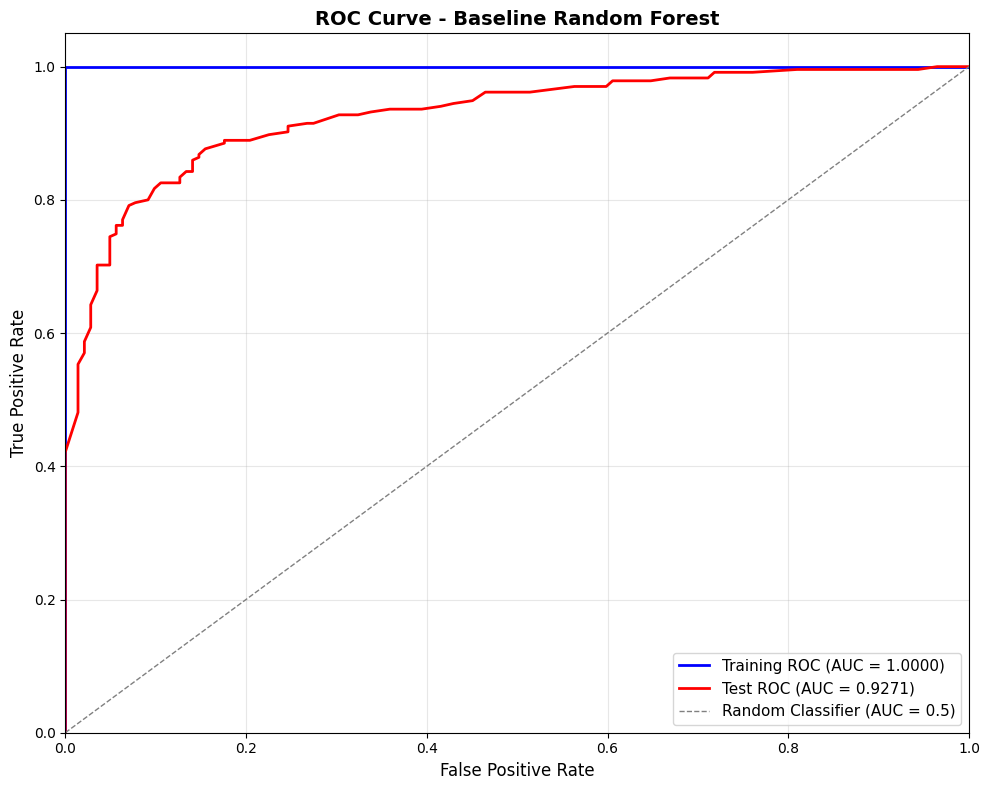


✅ ROC curves plotted!


In [9]:
# ============================================================================
# CELL 9: ROC CURVE ANALYSIS
# ============================================================================
"""
Plot ROC curve dan calculate AUC untuk training dan test sets.
"""

print("\n" + "="*80)
print("📈 ROC CURVE ANALYSIS")
print("="*80)

# Calculate ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc_test = auc(fpr_test, tpr_test)

print(f"\n📊 ROC-AUC Scores:")
print(f"   • Training Set: {roc_auc_train:.4f}")
print(f"   • Test Set: {roc_auc_test:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Training ROC
plt.plot(fpr_train, tpr_train, color='blue', lw=2, 
         label=f'Training ROC (AUC = {roc_auc_train:.4f})')

# Test ROC
plt.plot(fpr_test, tpr_test, color='red', lw=2,
         label=f'Test ROC (AUC = {roc_auc_test:.4f})')

# Diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', 
         label='Random Classifier (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Baseline Random Forest', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/20_baseline_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ ROC curves plotted!")


📈 PRECISION-RECALL CURVE ANALYSIS

📊 PR-AUC Scores:
   • Training Set: 1.0000
   • Test Set: 0.9577


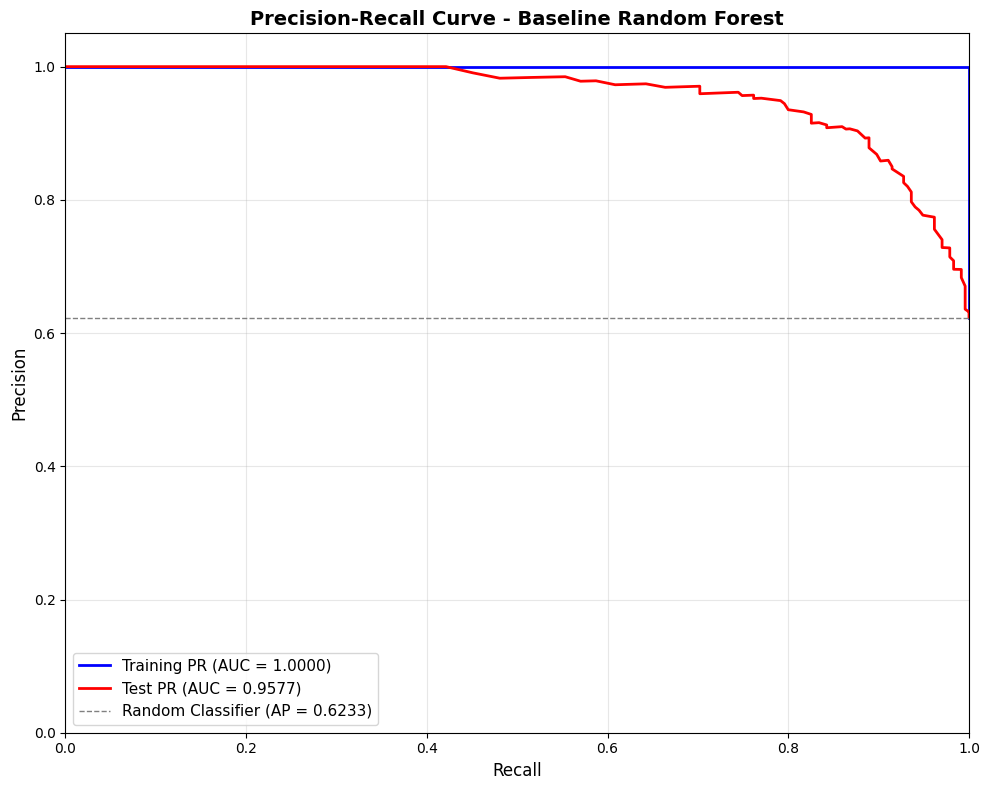


✅ PR curves plotted!

📌 Note: PR curves are more informative than ROC for imbalanced datasets


In [10]:
# ============================================================================
# CELL 10: PRECISION-RECALL CURVE
# ============================================================================
"""
Plot Precision-Recall curve (important untuk imbalanced data).
"""

print("\n" + "="*80)
print("📈 PRECISION-RECALL CURVE ANALYSIS")
print("="*80)

# Calculate PR curves
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred_proba)
pr_auc_train = average_precision_score(y_train, y_train_pred_proba)

precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)
pr_auc_test = average_precision_score(y_test, y_test_pred_proba)

print(f"\n📊 PR-AUC Scores:")
print(f"   • Training Set: {pr_auc_train:.4f}")
print(f"   • Test Set: {pr_auc_test:.4f}")

# Baseline (random classifier performance)
baseline_pr = (y_test == 1).sum() / len(y_test)

# Plot PR curves
plt.figure(figsize=(10, 8))

# Training PR
plt.plot(recall_train, precision_train, color='blue', lw=2,
         label=f'Training PR (AUC = {pr_auc_train:.4f})')

# Test PR
plt.plot(recall_test, precision_test, color='red', lw=2,
         label=f'Test PR (AUC = {pr_auc_test:.4f})')

# Baseline
plt.axhline(y=baseline_pr, color='gray', linestyle='--', lw=1,
            label=f'Random Classifier (AP = {baseline_pr:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Baseline Random Forest', 
          fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/21_baseline_pr_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ PR curves plotted!")
print("\n📌 Note: PR curves are more informative than ROC for imbalanced datasets")



🔄 CROSS-VALIDATION ANALYSIS

⚙️  CV Configuration:
   • Method: Stratified K-Fold
   • Number of folds: 5
   • Metrics: accuracy, precision, recall, f1, roc_auc

🔄 Running cross-validation...
   ✅ accuracy: 0.8269 (±0.0056)
   ✅ precision: 0.8665 (±0.0106)
   ✅ recall: 0.8543 (±0.0104)
   ✅ f1: 0.8602 (±0.0043)
   ✅ roc_auc: 0.8940 (±0.0054)

📊 Cross-Validation Summary:


,Metric,Mean Score,Std Dev,Min Score,Max Score
0,Accuracy,0.8269,0.0056,0.8179,0.8344
1,Precision,0.8665,0.0106,0.8519,0.8791
2,Recall,0.8543,0.0104,0.8404,0.8723
3,F1,0.8602,0.0043,0.8541,0.8654
4,Roc_auc,0.8940,0.0054,0.8874,0.9015


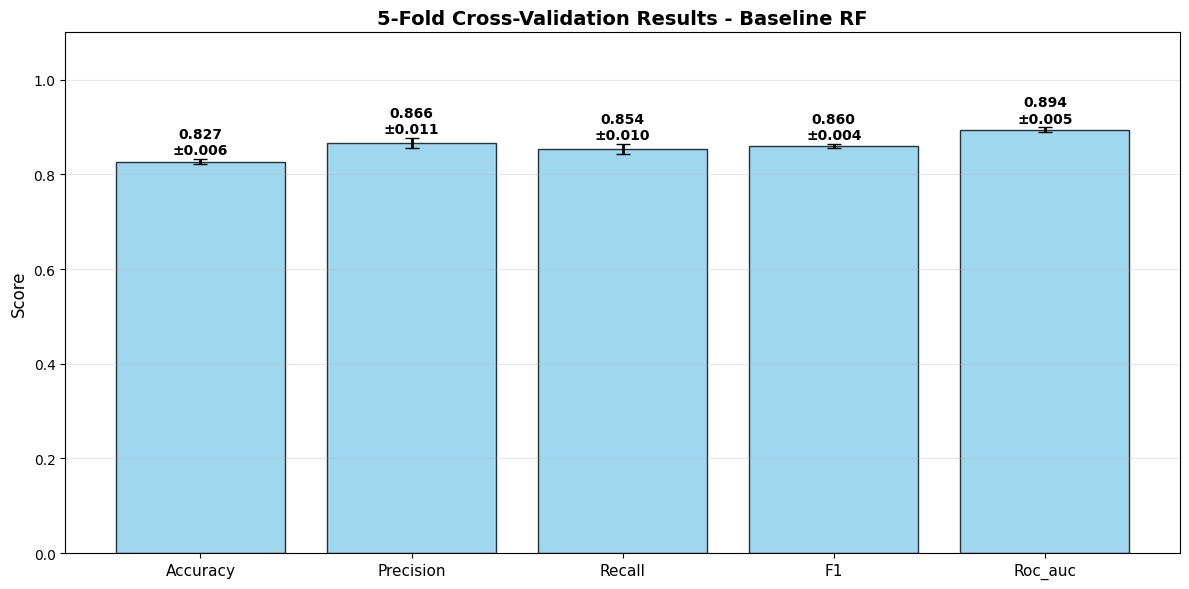


✅ Cross-validation completed!


In [11]:
# ============================================================================
# CELL 11: CROSS-VALIDATION ANALYSIS
# ============================================================================
"""
Perform 5-fold stratified cross-validation pada training set.
"""

print("\n" + "="*80)
print("🔄 CROSS-VALIDATION ANALYSIS")
print("="*80)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Scoring metrics
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

print(f"\n⚙️  CV Configuration:")
print(f"   • Method: Stratified K-Fold")
print(f"   • Number of folds: 5")
print(f"   • Metrics: {', '.join(scoring_metrics)}")

cv_results = {}

print(f"\n🔄 Running cross-validation...")
for metric in scoring_metrics:
    scores = cross_val_score(rf_baseline, X_train, y_train, 
                            cv=cv, scoring=metric, n_jobs=-1)
    cv_results[metric] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }
    print(f"   ✅ {metric}: {scores.mean():.4f} (±{scores.std():.4f})")

# Create CV results DataFrame
cv_df = pd.DataFrame({
    'Metric': [m.capitalize() for m in scoring_metrics],
    'Mean Score': [cv_results[m]['mean'] for m in scoring_metrics],
    'Std Dev': [cv_results[m]['std'] for m in scoring_metrics],
    'Min Score': [cv_results[m]['scores'].min() for m in scoring_metrics],
    'Max Score': [cv_results[m]['scores'].max() for m in scoring_metrics]
})

print("\n📊 Cross-Validation Summary:")
print("="*80)
display(cv_df.round(4))

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

metrics_labels = [m.capitalize() for m in scoring_metrics]
means = [cv_results[m]['mean'] for m in scoring_metrics]
stds = [cv_results[m]['std'] for m in scoring_metrics]

x_pos = np.arange(len(metrics_labels))
bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.8,
              color='skyblue', edgecolor='black', error_kw={'linewidth': 2})

# Add value labels
for i, (mean, std) in enumerate(zip(means, stds)):
    ax.text(i, mean + std + 0.01, f'{mean:.3f}\n±{std:.3f}',
            ha='center', fontsize=10, fontweight='bold')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('5-Fold Cross-Validation Results - Baseline RF', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics_labels, fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/22_baseline_cv_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Cross-validation completed!")


🔍 FEATURE IMPORTANCE ANALYSIS (GINI)

📊 Top 15 Most Important Features:


,Feature,Importance,Cumulative,Rank
8,country_UK,0.1224,0.1224,1
23,SS,0.1106,0.2331,2
19,Oscore,0.1076,0.3406,3
21,Cscore,0.0905,0.4311,4
0,Age_Encoded,0.0886,0.5198,5
17,Nscore,0.0784,0.5982,6
9,country_USA,0.0731,0.6713,7
20,Ascore,0.0716,0.7429,8
18,Escore,0.0688,0.8116,9
2,Education_Encoded,0.0651,0.8767,10



📊 Bottom 5 Least Important Features:
--------------------------------------------------------------------------------


,Feature,Importance,Cumulative,Rank
7,country_Republic of Ireland,0.0013,0.9969,20
10,ethnicity_Asian,0.0013,0.9982,21
13,ethnicity_Mixed-White/Asian,0.0012,0.9994,22
5,country_New Zealand,0.0005,0.9999,23
12,ethnicity_Mixed-Black/Asian,0.0001,1.0000,24



📈 Feature Importance Statistics:
   • Total features: 24
   • Mean importance: 0.0417
   • Std importance: 0.0426
   • Max importance: 0.1224 (country_UK)
   • Min importance: 0.0001
   • Top 10 features contribute: 87.67%


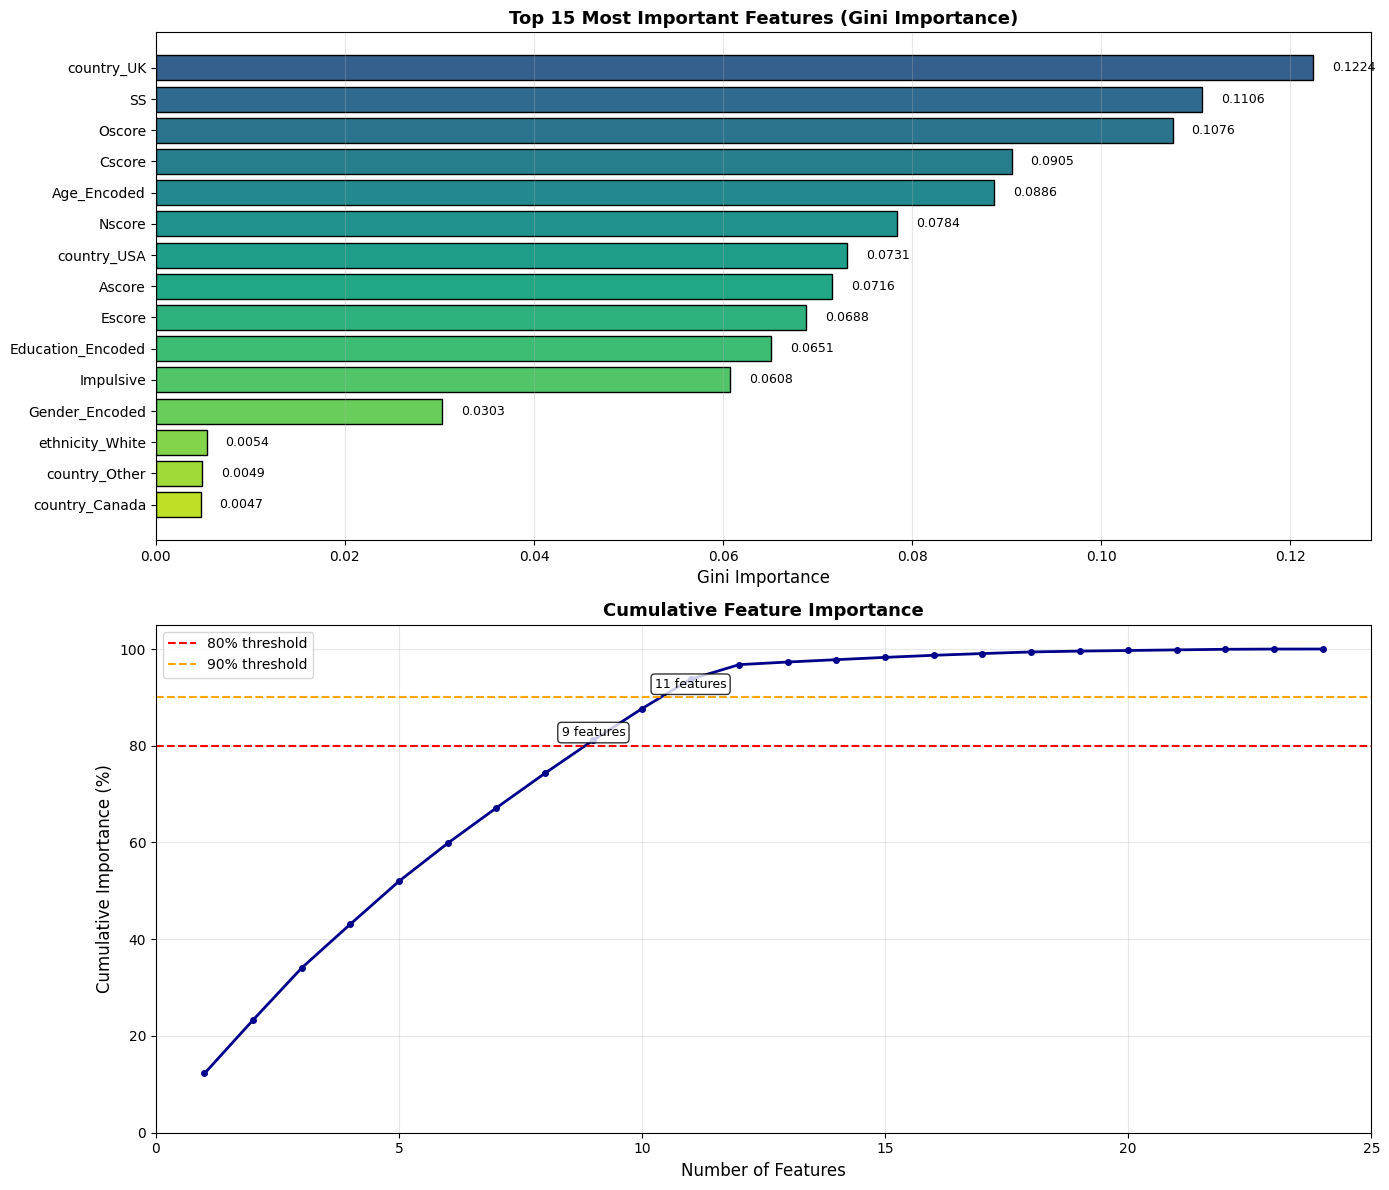


📌 Feature Selection Insights:
   • 9 features capture 80% of importance
   • 11 features capture 90% of importance

✅ Feature importance analysis completed!


In [12]:
# ============================================================================
# CELL 12: FEATURE IMPORTANCE ANALYSIS (GINI)
# ============================================================================
"""
Analyze feature importance menggunakan built-in Gini importance.
"""

print("\n" + "="*80)
print("🔍 FEATURE IMPORTANCE ANALYSIS (GINI)")
print("="*80)

# Get feature importances
feature_importances = rf_baseline.feature_importances_
feature_names = X_train.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Calculate cumulative importance
importance_df['Cumulative'] = importance_df['Importance'].cumsum()
importance_df['Rank'] = range(1, len(importance_df) + 1)

print("\n📊 Top 15 Most Important Features:")
print("="*80)
display(importance_df.head(15).round(4))

print("\n📊 Bottom 5 Least Important Features:")
print("-"*80)
display(importance_df.tail(5).round(4))

# Feature importance statistics
print(f"\n📈 Feature Importance Statistics:")
print(f"   • Total features: {len(feature_importances)}")
print(f"   • Mean importance: {feature_importances.mean():.4f}")
print(f"   • Std importance: {feature_importances.std():.4f}")
print(f"   • Max importance: {feature_importances.max():.4f} ({importance_df.iloc[0]['Feature']})")
print(f"   • Min importance: {feature_importances.min():.4f}")

# Top 10 features contribute what %?
top10_contribution = importance_df.head(10)['Importance'].sum()
print(f"   • Top 10 features contribute: {top10_contribution*100:.2f}%")

# Visualization 1: Top 15 features
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Bar chart - Top 15
top15 = importance_df.head(15)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, 15))

axes[0].barh(range(15), top15['Importance'], color=colors, edgecolor='black')
axes[0].set_yticks(range(15))
axes[0].set_yticklabels(top15['Feature'], fontsize=10)
axes[0].set_xlabel('Gini Importance', fontsize=12)
axes[0].set_title('Top 15 Most Important Features (Gini Importance)', 
                  fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top15.iterrows()):
    axes[0].text(row['Importance'] + 0.002, i, f"{row['Importance']:.4f}",
                va='center', fontsize=9)

# Cumulative importance curve
axes[1].plot(range(1, len(importance_df) + 1), 
            importance_df['Cumulative'] * 100,
            marker='o', linewidth=2, markersize=4, color='darkblue')
axes[1].axhline(y=80, color='red', linestyle='--', linewidth=1.5,
                label='80% threshold')
axes[1].axhline(y=90, color='orange', linestyle='--', linewidth=1.5,
                label='90% threshold')

axes[1].set_xlabel('Number of Features', fontsize=12)
axes[1].set_ylabel('Cumulative Importance (%)', fontsize=12)
axes[1].set_title('Cumulative Feature Importance', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, len(importance_df) + 1])
axes[1].set_ylim([0, 105])

# Find number of features for 80% and 90%
n_features_80 = (importance_df['Cumulative'] <= 0.80).sum() + 1
n_features_90 = (importance_df['Cumulative'] <= 0.90).sum() + 1

axes[1].text(n_features_80, 82, f'{n_features_80} features',
            ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
axes[1].text(n_features_90, 92, f'{n_features_90} features',
            ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('../results/figures/23_baseline_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📌 Feature Selection Insights:")
print(f"   • {n_features_80} features capture 80% of importance")
print(f"   • {n_features_90} features capture 90% of importance")
print("\n✅ Feature importance analysis completed!")

In [13]:

# ============================================================================
# CELL 13: SAVE BASELINE MODEL & RESULTS
# ============================================================================
"""
Save baseline model dan semua hasil evaluasi.
"""

print("\n" + "="*80)
print("💾 SAVING BASELINE MODEL & RESULTS")
print("="*80)

# Create directories
os.makedirs('../models', exist_ok=True)
os.makedirs('../results/metrics', exist_ok=True)

# 1. Save trained model
print("\n1️⃣ Saving trained model...")
model_path = '../models/baseline_rf_model.pkl'
joblib.dump(rf_baseline, model_path)
print(f"   ✅ Model saved: {model_path}")

# 2. Save predictions
print("\n2️⃣ Saving predictions...")
predictions_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_test_pred,
    'y_pred_proba': y_test_pred_proba
})
predictions_path = '../results/metrics/03_baseline_predictions.csv'
predictions_df.to_csv(predictions_path, index=False)
print(f"   ✅ Predictions saved: {predictions_path}")

# 3. Save metrics
print("\n3️⃣ Saving evaluation metrics...")
metrics_dict = {
    'model_info': {
        'model_type': 'RandomForestClassifier',
        'n_estimators': int(rf_baseline.n_estimators),
        'criterion': str(rf_baseline.criterion),
        'max_depth': rf_baseline.max_depth if rf_baseline.max_depth else 'None',
        'min_samples_split': int(rf_baseline.min_samples_split),
        'min_samples_leaf': int(rf_baseline.min_samples_leaf),
        'max_features': str(rf_baseline.max_features),
        'bootstrap': bool(rf_baseline.bootstrap),
        'random_state': int(rf_baseline.random_state),
        'training_time_seconds': float(training_time)
    },
    'training_metrics': {
        'accuracy': float(train_metrics['Accuracy']),
        'precision': float(train_metrics['Precision']),
        'recall': float(train_metrics['Recall (Sensitivity)']),
        'specificity': float(train_metrics['Specificity']),
        'f1_score': float(train_metrics['F1-Score']),
        'balanced_accuracy': float(train_metrics['Balanced Accuracy']),
        'roc_auc': float(train_metrics['ROC-AUC']),
        'pr_auc': float(train_metrics['PR-AUC']),
        'cohen_kappa': float(train_metrics['Cohen Kappa']),
        'mcc': float(train_metrics['MCC'])
    },
    'test_metrics': {
        'accuracy': float(test_metrics['Accuracy']),
        'precision': float(test_metrics['Precision']),
        'recall': float(test_metrics['Recall (Sensitivity)']),
        'specificity': float(test_metrics['Specificity']),
        'f1_score': float(test_metrics['F1-Score']),
        'balanced_accuracy': float(test_metrics['Balanced Accuracy']),
        'roc_auc': float(test_metrics['ROC-AUC']),
        'pr_auc': float(test_metrics['PR-AUC']),
        'cohen_kappa': float(test_metrics['Cohen Kappa']),
        'mcc': float(test_metrics['MCC'])
    },
    'cross_validation': {
        metric: {
            'mean': float(cv_results[metric]['mean']),
            'std': float(cv_results[metric]['std']),
            'scores': [float(s) for s in cv_results[metric]['scores']]
        } for metric in scoring_metrics
    },
    'confusion_matrix': {
        'training': {
            'true_negatives': int(cm_train[0, 0]),
            'false_positives': int(cm_train[0, 1]),
            'false_negatives': int(cm_train[1, 0]),
            'true_positives': int(cm_train[1, 1])
        },
        'test': {
            'true_negatives': int(cm_test[0, 0]),
            'false_positives': int(cm_test[0, 1]),
            'false_negatives': int(cm_test[1, 0]),
            'true_positives': int(cm_test[1, 1])
        }
    }
}

metrics_path = '../results/metrics/03_baseline_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics_dict, f, indent=4)
print(f"   ✅ Metrics saved: {metrics_path}")

# 4. Save feature importance
print("\n4️⃣ Saving feature importance...")
importance_path = '../results/metrics/03_baseline_feature_importance.csv'
importance_df.to_csv(importance_path, index=False)
print(f"   ✅ Feature importance saved: {importance_path}")

print("\n" + "="*80)
print("💾 ALL FILES SAVED SUCCESSFULLY!")
print("="*80)

print("\nSaved files:")
print("   📁 models/")
print("      └── baseline_rf_model.pkl")
print("\n   📁 results/metrics/")
print("      ├── 03_baseline_predictions.csv")
print("      ├── 03_baseline_metrics.json")
print("      └── 03_baseline_feature_importance.csv")
print("\n   📁 results/figures/")
print("      ├── 19_baseline_confusion_matrix.png")
print("      ├── 20_baseline_roc_curve.png")
print("      ├── 21_baseline_pr_curve.png")
print("      ├── 22_baseline_cv_results.png")
print("      └── 23_baseline_feature_importance.png")


💾 SAVING BASELINE MODEL & RESULTS

1️⃣ Saving trained model...
   ✅ Model saved: ../models/baseline_rf_model.pkl

2️⃣ Saving predictions...
   ✅ Predictions saved: ../results/metrics/03_baseline_predictions.csv

3️⃣ Saving evaluation metrics...
   ✅ Metrics saved: ../results/metrics/03_baseline_metrics.json

4️⃣ Saving feature importance...
   ✅ Feature importance saved: ../results/metrics/03_baseline_feature_importance.csv

💾 ALL FILES SAVED SUCCESSFULLY!

Saved files:
   📁 models/
      └── baseline_rf_model.pkl

   📁 results/metrics/
      ├── 03_baseline_predictions.csv
      ├── 03_baseline_metrics.json
      └── 03_baseline_feature_importance.csv

   📁 results/figures/
      ├── 19_baseline_confusion_matrix.png
      ├── 20_baseline_roc_curve.png
      ├── 21_baseline_pr_curve.png
      ├── 22_baseline_cv_results.png
      └── 23_baseline_feature_importance.png


In [14]:
# ============================================================================
# CELL 14: BASELINE MODEL SUMMARY REPORT
# ============================================================================
"""
Generate comprehensive summary report untuk baseline model.
"""

print("\n" + "="*80)
print("📋 BASELINE MODEL SUMMARY REPORT")
print("="*80)

print("\n" + "="*80)
print("1️⃣ MODEL CONFIGURATION")
print("="*80)

print("\n✅ Random Forest Classifier (Baseline - Default Parameters)")
print("-"*80)
print(f"   • n_estimators: {rf_baseline.n_estimators}")
print(f"   • criterion: {rf_baseline.criterion}")
print(f"   • max_depth: {rf_baseline.max_depth} (unlimited)")
print(f"   • min_samples_split: {rf_baseline.min_samples_split}")
print(f"   • min_samples_leaf: {rf_baseline.min_samples_leaf}")
print(f"   • max_features: {rf_baseline.max_features}")
print(f"   • bootstrap: {rf_baseline.bootstrap}")
print(f"   • Training time: {training_time:.2f} seconds")

print("\n" + "="*80)
print("2️⃣ PERFORMANCE METRICS")
print("="*80)

print("\n📊 Test Set Performance (PRIMARY EVALUATION):")
print("-"*80)
print(f"   • Accuracy:          {test_metrics['Accuracy']:.4f} ({test_metrics['Accuracy']*100:.2f}%)")
print(f"   • Precision:         {test_metrics['Precision']:.4f}")
print(f"   • Recall (Sens.):    {test_metrics['Recall (Sensitivity)']:.4f}")
print(f"   • Specificity:       {test_metrics['Specificity']:.4f}")
print(f"   • F1-Score:          {test_metrics['F1-Score']:.4f}")
print(f"   • Balanced Accuracy: {test_metrics['Balanced Accuracy']:.4f}")
print(f"   • ROC-AUC:           {test_metrics['ROC-AUC']:.4f}")
print(f"   • PR-AUC:            {test_metrics['PR-AUC']:.4f}")
print(f"   • Cohen's Kappa:     {test_metrics['Cohen Kappa']:.4f}")
print(f"   • MCC:               {test_metrics['MCC']:.4f}")

print("\n📊 Cross-Validation Results (5-Fold Stratified):")
print("-"*80)
for metric in scoring_metrics:
    mean = cv_results[metric]['mean']
    std = cv_results[metric]['std']
    print(f"   • {metric.capitalize():12s}: {mean:.4f} (±{std:.4f})")

print("\n📊 Confusion Matrix (Test Set):")
print("-"*80)
print(f"   • True Positives:  {cm_test[1, 1]:4d} (Correctly identified Users)")
print(f"   • True Negatives:  {cm_test[0, 0]:4d} (Correctly identified Non-Users)")
print(f"   • False Positives: {cm_test[0, 1]:4d} (Non-Users misclassified as Users)")
print(f"   • False Negatives: {cm_test[1, 0]:4d} (Users misclassified as Non-Users)")

# Calculate additional insights
total_users = cm_test[1, 0] + cm_test[1, 1]
total_nonusers = cm_test[0, 0] + cm_test[0, 1]
detected_users_pct = (cm_test[1, 1] / total_users * 100) if total_users > 0 else 0
detected_nonusers_pct = (cm_test[0, 0] / total_nonusers * 100) if total_nonusers > 0 else 0

print(f"\n   • {detected_users_pct:.1f}% of Users correctly detected")
print(f"   • {detected_nonusers_pct:.1f}% of Non-Users correctly detected")

print("\n" + "="*80)
print("3️⃣ FEATURE IMPORTANCE")
print("="*80)

print("\n📊 Top 10 Most Important Features:")
print("-"*80)
for i, (idx, row) in enumerate(importance_df.head(10).iterrows(), 1):
    print(f"   {i:2d}. {row['Feature']:30s}: {row['Importance']:.4f} ({row['Importance']*100:5.2f}%)")

print(f"\n📊 Feature Contribution:")
print(f"   • Top 5 features:  {importance_df.head(5)['Importance'].sum()*100:.2f}%")
print(f"   • Top 10 features: {importance_df.head(10)['Importance'].sum()*100:.2f}%")
print(f"   • Top 15 features: {importance_df.head(15)['Importance'].sum()*100:.2f}%")

print("\n" + "="*80)
print("4️⃣ MODEL DIAGNOSIS")
print("="*80)

# Overfitting check
print(f"\n🔍 Overfitting Analysis:")
print("-"*80)
train_test_gap = train_metrics['Accuracy'] - test_metrics['Accuracy']
print(f"   • Training Accuracy: {train_metrics['Accuracy']:.4f}")
print(f"   • Test Accuracy:     {test_metrics['Accuracy']:.4f}")
print(f"   • Accuracy Gap:      {train_test_gap:.4f}")

if train_test_gap > 0.10:
    print(f"   • Status: ⚠️  SIGNIFICANT OVERFITTING")
    print(f"   • Recommendation: Regularization needed (max_depth, min_samples_split)")
elif train_test_gap > 0.05:
    print(f"   • Status: ⚠️  MODERATE OVERFITTING")
    print(f"   • Recommendation: Consider tuning regularization parameters")
else:
    print(f"   • Status: ✅ GOOD GENERALIZATION")
    print(f"   • Recommendation: Model generalizes well to unseen data")

# Bias-Variance check
print(f"\n🔍 Bias-Variance Analysis:")
print("-"*80)
cv_std_accuracy = cv_results['accuracy']['std']
cv_mean_accuracy = cv_results['accuracy']['mean']

if cv_std_accuracy > 0.05:
    print(f"   • CV Std Dev: {cv_std_accuracy:.4f} (HIGH VARIANCE)")
    print(f"   • Status: ⚠️  Model is unstable across folds")
    print(f"   • Recommendation: Increase n_estimators or use more data")
elif cv_std_accuracy > 0.02:
    print(f"   • CV Std Dev: {cv_std_accuracy:.4f} (MODERATE VARIANCE)")
    print(f"   • Status: ⚠️  Some instability detected")
else:
    print(f"   • CV Std Dev: {cv_std_accuracy:.4f} (LOW VARIANCE)")
    print(f"   • Status: ✅ Model is stable")

if cv_mean_accuracy < 0.70:
    print(f"   • CV Mean: {cv_mean_accuracy:.4f} (LOW)")
    print(f"   • Status: ⚠️  HIGH BIAS - Model underfitting")
    print(f"   • Recommendation: Increase model complexity")
elif cv_mean_accuracy < 0.80:
    print(f"   • CV Mean: {cv_mean_accuracy:.4f} (MODERATE)")
    print(f"   • Status: ✅ Acceptable performance")
else:
    print(f"   • CV Mean: {cv_mean_accuracy:.4f} (HIGH)")
    print(f"   • Status: ✅ Good performance")

print("\n" + "="*80)
print("5️⃣ COMPARISON WITH LITERATURE")
print("="*80)

print("\n📚 Fehrman et al. (2017) Baseline:")
print("-"*80)
print("   • Method: Random Forest (per-drug classification)")
print("   • Best RF Accuracy: 74.3%")
print(f"   • Our Baseline Accuracy: {test_metrics['Accuracy']*100:.2f}%")

our_accuracy = test_metrics['Accuracy'] * 100
baseline_paper = 74.3

if our_accuracy > baseline_paper:
    diff = our_accuracy - baseline_paper
    print(f"   • Status: ✅ OUTPERFORMS baseline paper by {diff:.2f}%")
elif our_accuracy > baseline_paper - 5:
    diff = baseline_paper - our_accuracy
    print(f"   • Status: ✅ COMPARABLE to baseline paper (-{diff:.2f}%)")
else:
    diff = baseline_paper - our_accuracy
    print(f"   • Status: ⚠️  Below baseline paper by {diff:.2f}%")

print("\n📌 Note:")
print("   • Different problem formulation (binary vs per-drug)")
print("   • Our approach is more practical for screening")
print("   • Direct comparison should be interpreted with caution")

print("\n" + "="*80)
print("6️⃣ RECOMMENDATIONS FOR NEXT PHASES")
print("="*80)

print("\n✅ Strengths of Baseline Model:")
print("-"*80)
if test_metrics['ROC-AUC'] > 0.75:
    print("   • Good discriminative ability (ROC-AUC > 0.75)")
if test_metrics['Balanced Accuracy'] > 0.70:
    print("   • Balanced performance across classes")
if cv_std_accuracy < 0.03:
    print("   • Stable performance across folds")
if train_test_gap < 0.05:
    print("   • No significant overfitting")

print("\n⚠️  Areas for Improvement:")
print("-"*80)
improvement_areas = []

if test_metrics['Recall (Sensitivity)'] < 0.80:
    improvement_areas.append("Recall (Sensitivity)")
    print(f"   • Recall: {test_metrics['Recall (Sensitivity)']:.4f} (Target: >0.80)")
    
if test_metrics['Precision'] < 0.75:
    improvement_areas.append("Precision")
    print(f"   • Precision: {test_metrics['Precision']:.4f} (Target: >0.75)")

if test_metrics['F1-Score'] < 0.80:
    improvement_areas.append("F1-Score")
    print(f"   • F1-Score: {test_metrics['F1-Score']:.4f} (Target: >0.80)")

if train_test_gap > 0.05:
    improvement_areas.append("Overfitting")
    
if not improvement_areas:
    print("   • Baseline performance is already strong!")
    print("   • Focus on marginal improvements through tuning")

print("\n🎯 Recommendations for Fase 4 (Hyperparameter Tuning):")
print("-"*80)
print("   1. Increase n_estimators (100 → 200/300/500)")
if train_test_gap > 0.05:
    print("   2. Add max_depth constraint (10/20/30/40)")
    print("   3. Increase min_samples_split (2 → 5/10/20)")
print("   4. Try different max_features ('sqrt' vs 'log2' vs 0.3/0.5)")
print("   5. Optimize for ROC-AUC in RandomizedSearchCV")

print("\n🎯 Recommendations for Fase 5 (Class Imbalance):")
print("-"*80)
imbalance_ratio_actual = test_dist[0] / test_dist[1] if test_dist[1] > 0 else 0
print(f"   • Current imbalance ratio: {imbalance_ratio_actual:.2f}:1")

if imbalance_ratio_actual > 1.5 or imbalance_ratio_actual < 0.67:
    print("   • Consider SMOTE/ADASYN for better minority class detection")
    print("   • Compare class_weight='balanced' vs resampling")
else:
    print("   • Class imbalance is moderate")
    print("   • SMOTE/ADASYN may provide marginal improvements")

print("\n🎯 Feature Engineering for Future Work:")
print("-"*80)
low_importance_count = (importance_df['Importance'] < 0.01).sum()
print(f"   • {low_importance_count} features have very low importance (<1%)")
print("   • Consider feature selection to reduce complexity")
print(f"   • Top 10 features contribute {importance_df.head(10)['Importance'].sum()*100:.1f}%")



📋 BASELINE MODEL SUMMARY REPORT

1️⃣ MODEL CONFIGURATION

✅ Random Forest Classifier (Baseline - Default Parameters)
--------------------------------------------------------------------------------
   • n_estimators: 100
   • criterion: gini
   • max_depth: None (unlimited)
   • min_samples_split: 2
   • min_samples_leaf: 1
   • max_features: sqrt
   • bootstrap: True
   • Training time: 0.36 seconds

2️⃣ PERFORMANCE METRICS

📊 Test Set Performance (PRIMARY EVALUATION):
--------------------------------------------------------------------------------
   • Accuracy:          0.8647 (86.47%)
   • Precision:         0.9035
   • Recall (Sens.):    0.8766
   • Specificity:       0.8451
   • F1-Score:          0.8898
   • Balanced Accuracy: 0.8608
   • ROC-AUC:           0.9271
   • PR-AUC:            0.9577
   • Cohen's Kappa:     0.7147
   • MCC:               0.7152

📊 Cross-Validation Results (5-Fold Stratified):
---------------------------------------------------------------------------

In [15]:
# ============================================================================
# CELL 15: FINAL SUMMARY & NEXT STEPS
# ============================================================================
"""
Final summary dan preparation untuk fase selanjutnya.
"""

print("\n" + "="*80)
print("🎉 NOTEBOOK 03 COMPLETED!")
print("="*80)

print("\n📊 BASELINE MODEL SUMMARY:")
print("-"*80)
print(f"   • Model: Random Forest (Default Parameters)")
print(f"   • Training samples: {len(y_train)}")
print(f"   • Test samples: {len(y_test)}")
print(f"   • Features: {X_train.shape[1]}")
print(f"   • Test Accuracy: {test_metrics['Accuracy']:.4f} ({test_metrics['Accuracy']*100:.2f}%)")
print(f"   • Test ROC-AUC: {test_metrics['ROC-AUC']:.4f}")
print(f"   • Test F1-Score: {test_metrics['F1-Score']:.4f}")
print(f"   • Training time: {training_time:.2f} seconds")

print("\n📁 FILES GENERATED:")
print("-"*80)
print("   1. Saved model:")
print("      • models/baseline_rf_model.pkl")
print("\n   2. Evaluation metrics:")
print("      • results/metrics/03_baseline_predictions.csv")
print("      • results/metrics/03_baseline_metrics.json")
print("      • results/metrics/03_baseline_feature_importance.csv")
print("\n   3. Visualizations (5 figures):")
print("      • results/figures/19_baseline_confusion_matrix.png")
print("      • results/figures/20_baseline_roc_curve.png")
print("      • results/figures/21_baseline_pr_curve.png")
print("      • results/figures/22_baseline_cv_results.png")
print("      • results/figures/23_baseline_feature_importance.png")

print("\n✅ BASELINE ESTABLISHED:")
print("-"*80)
print("   ✅ Model trained and evaluated")
print("   ✅ Performance metrics documented")
print("   ✅ Feature importance analyzed")
print("   ✅ Benchmark set for optimization")

print("\n📝 NEXT STEPS:")
print("="*80)

print("\n✅ Fase 3 Complete: Random Forest Baseline")
print("\n➡️  Fase 4: Hyperparameter Tuning (Notebook 04)")
print("   • RandomizedSearchCV with 100 iterations")
print("   • 5-fold stratified cross-validation")
print("   • Optimize for ROC-AUC")
print("   • Parameter search space:")
print("      - n_estimators: [100, 200, 300, 500, 1000]")
print("      - max_depth: [10, 20, 30, 40, None]")
print("      - min_samples_split: [2, 5, 10, 20]")
print("      - min_samples_leaf: [1, 2, 4, 8]")
print("      - max_features: ['sqrt', 'log2', 0.3, 0.5]")
print("      - criterion: ['gini', 'entropy']")

print("\n➡️  Fase 5: Class Imbalance Handling (Notebook 05)")
print("   • Compare 4 strategies:")
print("      1. No resampling (baseline)")
print("      2. SMOTE")
print("      3. ADASYN")
print("      4. Class weighting")
print("   • Select best strategy based on metrics")

print("\n" + "="*80)
print("🚀 READY FOR OPTIMIZATION!")
print("="*80)

print("\n💡 Key Takeaways:")
print("   • Baseline model provides solid foundation")
print("   • Clear benchmark for improvement")
print("   • Feature importance insights guide optimization")
print("   • Ready to explore hyperparameter space")

print("\n" + "="*80)
print("📋 CHECKLIST FOR NEXT PHASE:")
print("="*80)
print("   ✅ Baseline model saved (baseline_rf_model.pkl)")
print("   ✅ Baseline metrics documented (JSON)")
print("   ✅ Feature importance analyzed (CSV)")
print("   ✅ Visualizations created (5 figures)")
print("   ✅ Cross-validation completed (5-fold)")
print("   ✅ Benchmark established for comparison")

print("\n🎯 Expected Improvements in Fase 4:")
print("-"*80)
print(f"   • Baseline Test Accuracy: {test_metrics['Accuracy']*100:.2f}%")
print("   • Target Optimized Accuracy: 80-85%")
print(f"   • Baseline ROC-AUC: {test_metrics['ROC-AUC']:.4f}")
print("   • Target Optimized ROC-AUC: 0.85+")
print("   • Expected improvement: 5-10% across all metrics")

print("\n" + "="*80)
print("✅ NOTEBOOK 03: BASELINE RF - COMPLETED SUCCESSFULLY!")
print("="*80)

# Final verification
print("\n🔍 Final Verification:")
print("-"*80)
print(f"   ✅ Model type: {type(rf_baseline).__name__}")
print(f"   ✅ Model trained: {hasattr(rf_baseline, 'estimators_')}")
print(f"   ✅ Predictions generated: {len(y_test_pred)} samples")
print(f"   ✅ Metrics calculated: {len(metrics_dict['test_metrics'])} metrics")
print(f"   ✅ Feature importance: {len(importance_df)} features")
print(f"   ✅ CV folds completed: {len(cv_results['accuracy']['scores'])} folds")

print("\n" + "="*80)
print("🎓 ACADEMIC OUTPUT CHECKLIST:")
print("="*80)
print("   ✅ Confusion Matrix (Training & Test)")
print("   ✅ Classification Report (Precision, Recall, F1)")
print("   ✅ ROC Curve with AUC")
print("   ✅ Precision-Recall Curve with AP")
print("   ✅ Cross-Validation Results (5-fold)")
print("   ✅ Feature Importance Analysis (Gini)")
print("   ✅ Model Diagnosis (Overfitting, Bias-Variance)")
print("   ✅ Comparison with Literature (Fehrman et al.)")
print("   ✅ Comprehensive Summary Report")

print("\n" + "="*80)
print("📚 READY FOR THESIS/PAPER WRITING!")
print("="*80)
print("\nThis notebook provides:")
print("   • Baseline performance metrics for Results section")
print("   • Feature importance for Discussion section")
print("   • Visualizations for Figures in paper")
print("   • Comparison data for Literature Review")
print("   • Methodology validation for Methods section")

print("\n" + "="*80)
print("END OF NOTEBOOK 03")
print("="*80)


🎉 NOTEBOOK 03 COMPLETED!

📊 BASELINE MODEL SUMMARY:
--------------------------------------------------------------------------------
   • Model: Random Forest (Default Parameters)
   • Training samples: 1508
   • Test samples: 377
   • Features: 24
   • Test Accuracy: 0.8647 (86.47%)
   • Test ROC-AUC: 0.9271
   • Test F1-Score: 0.8898
   • Training time: 0.36 seconds

📁 FILES GENERATED:
--------------------------------------------------------------------------------
   1. Saved model:
      • models/baseline_rf_model.pkl

   2. Evaluation metrics:
      • results/metrics/03_baseline_predictions.csv
      • results/metrics/03_baseline_metrics.json
      • results/metrics/03_baseline_feature_importance.csv

   3. Visualizations (5 figures):
      • results/figures/19_baseline_confusion_matrix.png
      • results/figures/20_baseline_roc_curve.png
      • results/figures/21_baseline_pr_curve.png
      • results/figures/22_baseline_cv_results.png
      • results/figures/23_baseline_featur